In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.cross_validation import LeaveOneOut, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR




from count_lagged_complaints import *
from chris_rasmus_graph_features import *

from processing import *
%matplotlib inline

In [2]:
offc = pd.read_csv('/Users/Mehraveh/Desktop/policy_lab/toy.officer_data.csv',sep=',')
cmpl = pd.read_csv('/Users/Mehraveh/Desktop/policy_lab/toy.complaint_data.csv', sep=',')

In [11]:
scale_days = 365
last_train_year = 2012
base_year = last_train_year
base_month = 12
base_day = 31
lag_max = 4
deg_thresh = 5

cmpl_severity = add_complaint_severity(cmpl)
r = add_complaints_by_year_and_severity(last_train_year, lag_max, cmpl_severity, offc) 

/Users/Mehraveh/Desktop/yins-datahack-2017/processing.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x['year'] = pd.DatetimeIndex(x['incident_date']).year


Adding graph features

In [12]:
complaint_df = add_lag_to_complaints(cmpl_severity, scale_days, base_year, base_month, base_day)


# build bipartite graph
G = build_bipartite_graph(complaint_df)
officer_ids = offc['officer_id'].unique()


# get feature dictionaries
num_nbr_complaints_dict = num_of_nbr_complaints(G, officer_ids, lag_max)
num_high_offenders = num_high_offender_nbrs(G, officer_ids, deg_thresh)
num_nbr_complaints_dict_pf = num_of_nbr_complaints_past_future(G, officer_ids, lag_max)


In [13]:
A=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_nbr_complaints_dict.items()])).transpose()
A.columns = ['cmpl0','cmpl1','cmpl2','cmpl3']

B=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_high_offenders.items()])).transpose() 
B.columns = ['num_high_offndr']
C=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in num_nbr_complaints_dict_pf.items()])).transpose()
C.columns = ['cmpl0_p','cmpl1_p','cmpl2_p','cmpl3_p','cmpl0_f','cmpl1_f','cmpl2_f','cmpl3_f']


r_A = r.merge(A, left_on = 'officer_id', right_index = 1, how = 'outer')
r_AB = r_A.merge(B, left_on = 'officer_id', right_index = 1, how = 'outer')
r_AB = r_AB.fillna(0);
r_C = r_AB.merge(C, left_on = 'officer_id', right_index = 1, how = 'outer')
r_C.head()
r_C.columns

Index(['first.name', 'last.name', 'appointed.date', 'race', 'gender',
       'birth.year', 'age', 'rank', 'primary', 'secondary', 'tertiary',
       'officer_id', 'LowSeverity_Lag0', 'LowSeverity_Lag-1',
       'LowSeverity_Lag-2', 'LowSeverity_Lag-3', 'MedSeverity_Lag0',
       'MedSeverity_Lag-1', 'MedSeverity_Lag-2', 'MedSeverity_Lag-3',
       'HighSeverity_Lag0', 'HighSeverity_Lag-1', 'HighSeverity_Lag-2',
       'HighSeverity_Lag-3', 'cmpl0', 'cmpl1', 'cmpl2', 'cmpl3',
       'num_high_offndr', 'cmpl0_p', 'cmpl1_p', 'cmpl2_p', 'cmpl3_p',
       'cmpl0_f', 'cmpl1_f', 'cmpl2_f', 'cmpl3_f'],
      dtype='object')

Generating feature matrix

In [14]:
# Making X vector (features)
# X = r_AB
X=r_C

#Dropping "FirstName", "LastName", "BirthYear","Rank"
X = X.drop(X.columns[[0,1,5,7,11]], axis=1)
# Getting years from apponted dates and normalizing
# temp = X[X.columns[0]].astype(str).str[0:4].astype(int)
# X[X.columns[0]] = (temp-np.mean(temp))/np.std(temp)
X[X.columns[0]] = X[X.columns[0]].astype(str).str[0:4].astype(int)


#Encoding categorical variables
X_cat = X[X.columns[[1,2]]]
XX=X_cat.apply(LabelEncoder().fit_transform)
X[X.columns[[1,2]]] = XX
np.where(np.isnan(X))
X_race = pd.get_dummies(X['race'])
X_race.columns = ['race0','race1','race2','race3']
X = X.drop(X.columns[[1]], axis=1)
X = X.join(X_race, how='outer')

X.head()
X.columns

Index(['appointed.date', 'gender', 'age', 'primary', 'secondary', 'tertiary',
       'LowSeverity_Lag0', 'LowSeverity_Lag-1', 'LowSeverity_Lag-2',
       'LowSeverity_Lag-3', 'MedSeverity_Lag0', 'MedSeverity_Lag-1',
       'MedSeverity_Lag-2', 'MedSeverity_Lag-3', 'HighSeverity_Lag0',
       'HighSeverity_Lag-1', 'HighSeverity_Lag-2', 'HighSeverity_Lag-3',
       'cmpl0', 'cmpl1', 'cmpl2', 'cmpl3', 'num_high_offndr', 'cmpl0_p',
       'cmpl1_p', 'cmpl2_p', 'cmpl3_p', 'cmpl0_f', 'cmpl1_f', 'cmpl2_f',
       'cmpl3_f', 'race0', 'race1', 'race2', 'race3'],
      dtype='object')

Generating output vector

In [15]:
# Making Y vector

Y = add_complaints_by_year(2015, 2, cmpl, offc) 
Y=Y[[Y.columns[Y.shape[1]-1],Y.columns[Y.shape[1]-2]]]
Y=Y.sum(axis=1)

Predictive models

1.0


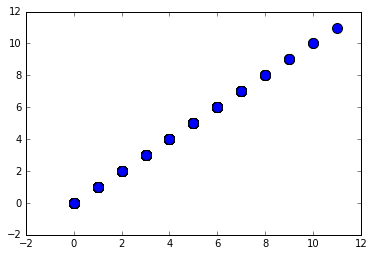

In [16]:
# LINEAR model


clf = linear_model.LinearRegression()
predicts = cross_val_predict(clf, X, Y, cv=3)

# clf.fit(X,Y)
# predicts = clf.predict(X)

plt.scatter(Y,predicts, s=100)
mean_squared_error(Y, predicts)
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)

In [ ]:
# GBM

clf = GradientBoostingRegressor(n_estimators=500,learning_rate=0.05,min_samples_split=5,
        min_samples_leaf=15,max_depth=5,max_features='sqrt',random_state=12,
        subsample =0.8,verbose=0,warm_start = True)

predicts = cross_val_predict(clf, X, Y, cv=3)

# clf.fit(X,Y)
# predicts = clf.predict(X)

mean_squared_error(Y, predicts)
plt.plot(Y,predicts,'*')
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)

# clf.fit(X,Y)
# imp = clf.feature_importances_


In [ ]:
plt.bar(np.arange(0,np.shape(X)[1]),imp)

In [ ]:
clf = RandomForestRegressor(n_estimators=100)
predicts = cross_val_predict(clf, X, Y, cv=3)

# clf.fit(X,Y)
# predicts = clf.predict(X)

mean_squared_error(Y, predicts)
plt.plot(Y,predicts,'*')
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)

clf.fit(X,Y)
imp = clf.feature_importances_


In [ ]:
clf = SVR(kernel='rbf', degree=3, gamma='auto')

predicts = cross_val_predict(clf, X, Y, cv=3)

#clf.fit(X2,Y)
#predicts = clf.predict(X2)

mean_squared_error(Y, predicts)
plt.plot(Y,predicts,'*')
correlation = np.corrcoef(Y, predicts)[0,1]
print(correlation)